Problem Statement:


A major agricultural company needs you to help them maximize growth efficiency, save resources and optimize their production. To achieve these things, the company needs to have an accurate weather prediction algorithm which will improve their decision making on typical farming activities such as planting and irrigating.

Using historical weather information from their region, can you predict what the weather will be in the next few days? Please note that areas A through E and the target area where you need to predict the weather, are all neighboring regions. The location of each region is not available.

This is a beginner-level practice competition and your goal is to predict the next day’s weather (N: No rain L: Light rain H: Heavy rain) using the prior day’s weather data.

## Install libraries

In [ ]:
%pip install lightgbm

## Import libraries

In [48]:
# essentials
import numpy as np 
import pandas as pd 

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# ml
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report, auc, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_predict
import lightgbm as lgb
from lightgbm import LGBMClassifier
import joblib

pd.set_option('display.max_columns', None)


First we import the necessary libraries we need.

## Helper functions

In [49]:
def missing_vals(df, drop=False, threshold=70):
    '''
    return missing values and percentages in a data frame
    also has option to drop columns with missing values
    '''
    missing_df = (
        df.isnull()
        .sum()
        .to_frame(name="counts")
        .query("counts > 0")
        .assign(percentage=lambda x: round((x.counts / len(df)) * 100, 2))
        .sort_values("counts", ascending=False)
    )

    if drop == True:
        to_drop = list(missing_df.query(f"percentage > {threshold}").index)
        print(f"dropped columns {to_drop}")
        df = df.drop(to_drop, axis=1)
        return df

    return missing_df

## Load data

In [50]:
train_a = pd.read_csv("data/comp_datasets_train/region_A_train.csv")
train_b = pd.read_csv("data/comp_datasets_train/region_B_train.csv")
train_c = pd.read_csv("data/comp_datasets_train/region_C_train.csv")
train_d = pd.read_csv("data/comp_datasets_train/region_D_train.csv")
train_e = pd.read_csv("data/comp_datasets_train/region_E_train.csv")

test_a = pd.read_csv("data/comp_datasets_test/region_A_test.csv")
test_b = pd.read_csv("data/comp_datasets_test/region_B_test.csv")
test_c = pd.read_csv("data/comp_datasets_test/region_C_test.csv")
test_d = pd.read_csv("data/comp_datasets_test/region_D_test.csv")
test_e = pd.read_csv("data/comp_datasets_test/region_E_test.csv")

labels_df = pd.read_csv("data/comp_datasets_train/solution_train.csv")

First we load the train and test data using the `read_csv` function. We also load the labels data which is the forms the target for our training dataset.

Since our training data is split into 5 regions, we have to combine them into one single dataset, where the region would become a feature.

## Data Preprocessing

In [51]:
train = pd.concat([train_a ,train_b ,train_c ,train_d ,train_e], keys=["A", "B", "C", "D", "E"])
train

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

We first concatenate all the train datasets with specific regions, and set the keys as the region names

In [52]:
train = train.reset_index()
train.rename(columns = {"level_0": "region"}, inplace=True)
train.drop(columns=['level_1'], inplace=True)
train.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


We can then reset index at the first level (the region names), and then name the column as region.

In [53]:
print(f"The dataset contains {train.shape[0]} samples and "
      f"{train.shape[1]} columns")

The dataset contains 2830 samples and 12 columns


## EDA

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   2830 non-null   object 
 1   date                     2830 non-null   object 
 2   avg.temp                 2830 non-null   float64
 3   max.temp                 2830 non-null   float64
 4   min.temp                 2830 non-null   float64
 5   precipitation            2830 non-null   float64
 6   avg.wind.speed           2830 non-null   float64
 7   max.wind.speed           2830 non-null   float64
 8   max.wind.speed.dir       2830 non-null   object 
 9   max.inst.wind.speed      2830 non-null   float64
 10  max.inst.wind.speed.dir  2830 non-null   object 
 11  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(4)
memory usage: 265.4+ KB


### Missing data

In [55]:
missing_vals(train)

,counts,percentage
min.atmos.pressure,2264,80.0


min.atmos.pressure is the only variable with missing data (80% in fact), we'll deal with this later.

In [56]:
train.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

the index above grabs all the features we are using to predict the target variable, label

### Histogram of all numerical features

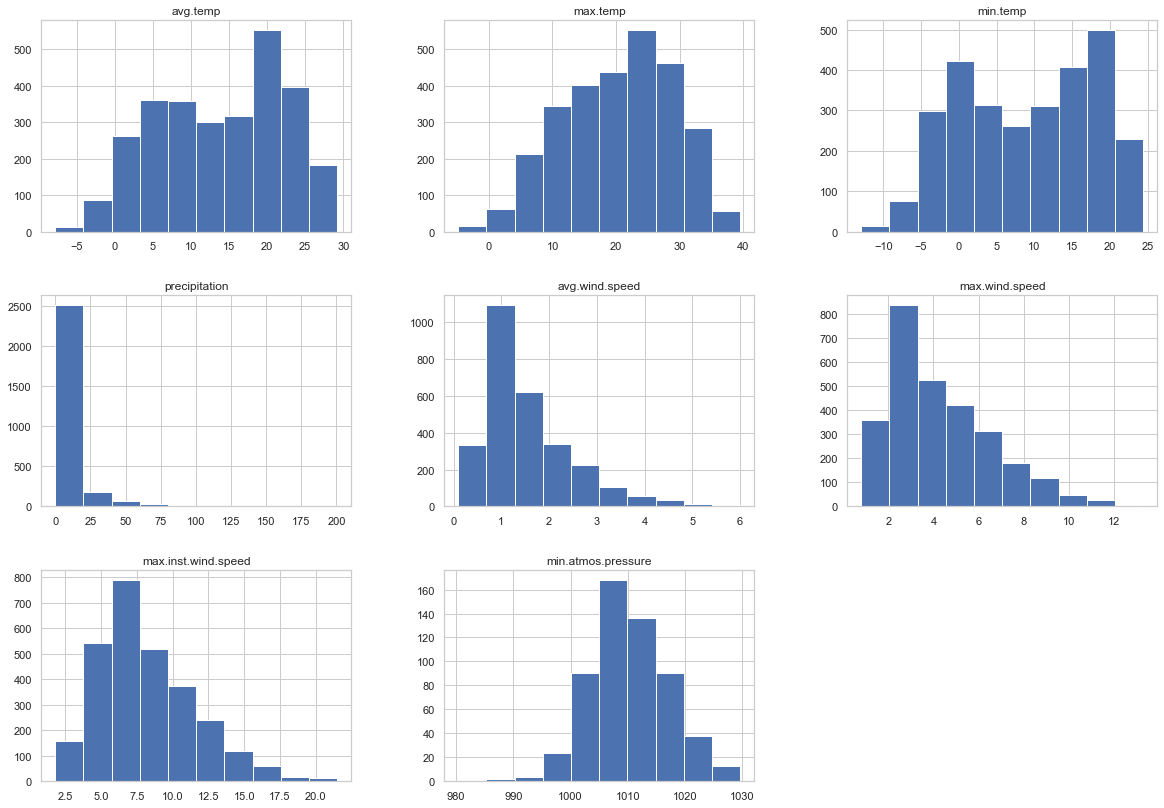

In [57]:
_ = train.hist(figsize=(20, 14))

`precipitation` is heavily right skewed, along with `avg.wind.speed` and `max.wind.speed` being right skewed as well.

### line plot

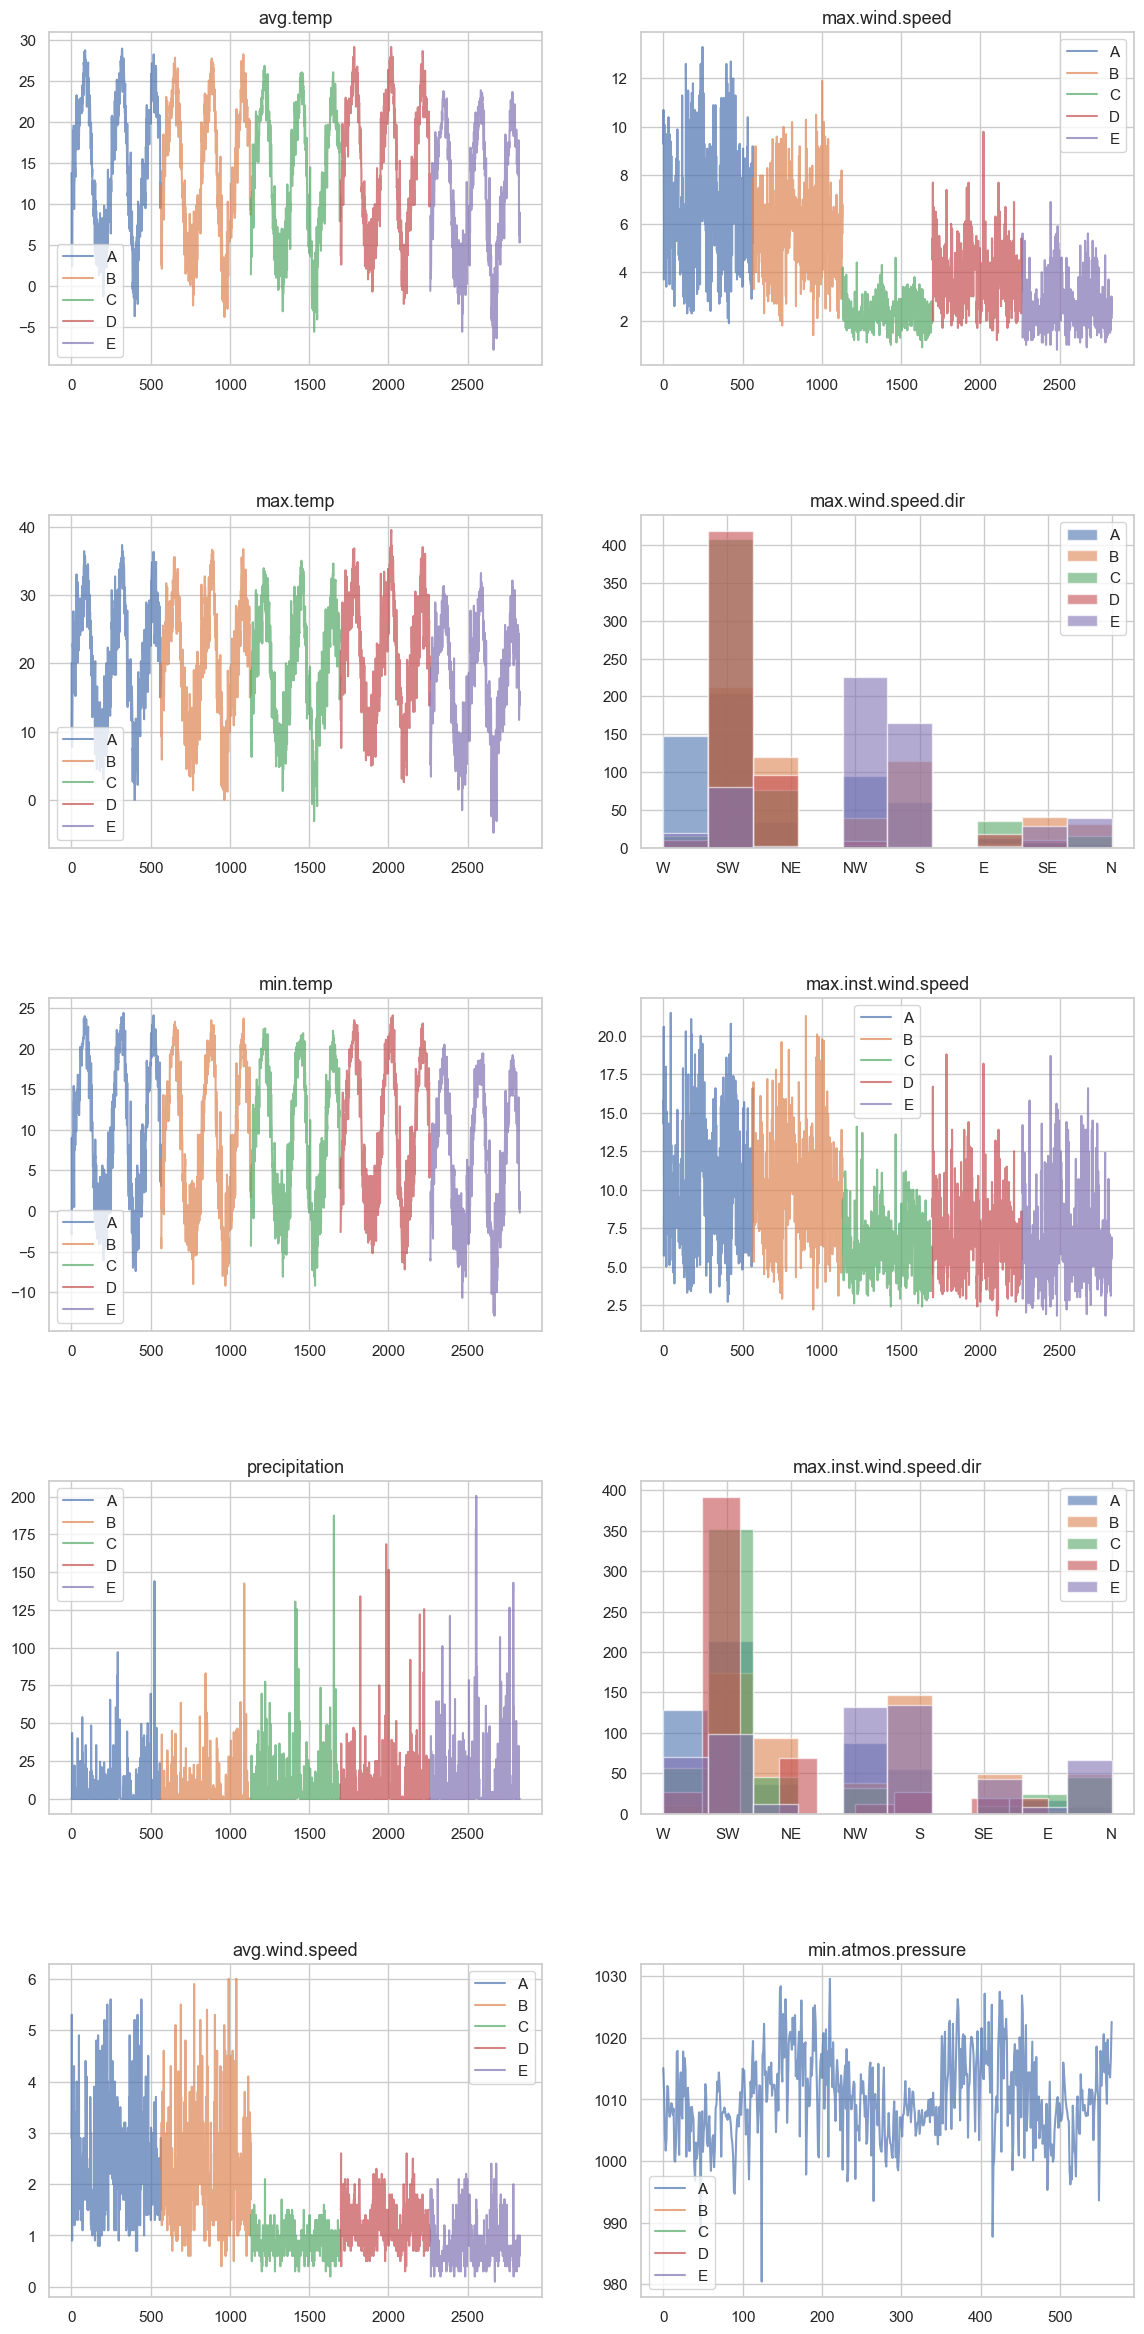

In [58]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(train.columns[2:]):
    if train[col_name].dtype == 'O':
        train.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.6);
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]);
    else:
        train.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.45)

From the plots, we see that the patterns in the data are very similar except for regions C, D, E for min.wind.speed and avg.wind.speed which are on the lower scale.

Now that we’ve explored the data a little, we check for missing values in our data.



## Missing Values

In [59]:
missing_vals(train)

,counts,percentage
min.atmos.pressure,2264,80.0


Let’s also use a heatmap to visualize the missing data for that column.


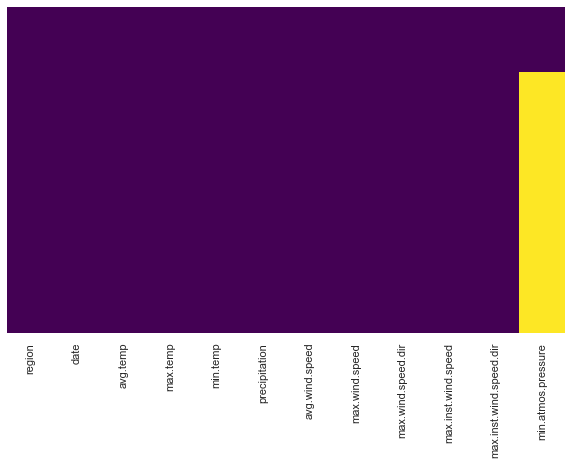

In [60]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), yticklabels=False, cmap='viridis', cbar=False);


There are multiple ways we can deal with missing data.

Let’s first look at the distribution of the column with missing values.

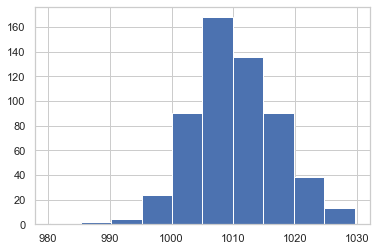

In [61]:
train['min.atmos.pressure'].hist();

Since the distribution of the column is pretty normal, let’s impute the missing data with the mean.



In [62]:
mean_atmos = train['min.atmos.pressure'].mean()
train.fillna(mean_atmos, inplace=True)

In [63]:
missing_vals(train)

,counts,percentage


## Feature Engineering

Let’s first add the labels to our data.



In [64]:
train = train.merge(labels_df, on="date")

Then we take a look at the categorical columns for our dataset.

In [65]:
train.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir',
       'label'],
      dtype='object')

We’ll have to convert the categorical features, including the target variable to a numerical format.

Let’s use scikit-learn’s Label Encoder to do that.

Here’s an example of using LabelEncoder() on the label column



In [66]:
le = LabelEncoder()
le.fit(train['label'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'H': 0, 'L': 1, 'N': 2}

### Creating new weather features
Since we’re given some weather features, there are interesting new features we can engineer.

One example is the Beaufort scale, which is “an empirical measure that relates wind speed to observed conditions at sea or on land.”

Below is a function to do our feature engineering.

In [67]:
BEAUFORT = [
    (0, 0, 0.3),
    (1, 0.3, 1.6),
    (2, 1.6, 3.4),
    (3, 3.4, 5.5),
    (4, 5.5, 8),
    (5, 8, 10.8),
    (6, 10.8, 13.9),
    (7, 13.9, 17.2),
    (8, 17.2, 20.8),
    (9, 20.8, 24.5),
    (10, 24.5, 28.5),
    (11, 28.5, 33),
    (12, 33, 200),
]


def feature_eng(df):
    le = LabelEncoder()
    
    cat_cols = [c for c in df.select_dtypes('object').columns if c not in ['region', 'date']]

    for c in cat_cols:
        df[c] = le.fit_transform(df[c])

    # wind speed is in meter/second
    # convert to knots to obtain beaufort scale
    for item in BEAUFORT:
        df.loc[
            (df["avg.wind.speed"] * 1.944 >= item[1]) & (df["avg.wind.speed"] * 1.944 < item[2]),
            "avg_beaufort_scale",
        ] = item[0]
        df.loc[
            (df["max.wind.speed"] * 1.944 >= item[1]) & (df["max.wind.speed"] * 1.944 < item[2]),
            "max_beaufort_scale",
        ] = item[0]

    df['avg_beaufort_scale'] = df['avg_beaufort_scale'].astype(int)
    df['max_beaufort_scale'] = df['max_beaufort_scale'].astype(int)

    return df

we apply this function to our train data

In [68]:
train = feature_eng(train)

## Prepare train data

In [69]:
train.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure,label,avg_beaufort_scale,max_beaufort_scale
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,7,14.3,7,1015.100000,2,4,8
1,B,229b70a3,2.6,9.3,-3.3,0.0,2.8,6.3,3,11.4,3,1010.216254,2,3,6
2,C,229b70a3,1.4,9.0,-4.3,0.0,1.0,2.9,6,8.2,1,1010.216254,2,2,4
3,D,229b70a3,3.7,11.7,-2.6,0.0,1.5,5.4,6,9.4,4,1010.216254,2,2,5
4,E,229b70a3,-0.6,5.2,-5.9,0.0,1.5,3.8,3,9.8,7,1010.216254,2,2,4


In [70]:
train.select_dtypes('object').columns

Index(['region', 'date'], dtype='object')

It’s time to pivot our data into the longer format, which means instead of the region being a column, each feature will have its own region, such as avg.temp_A, avg.temp_B, until avg.temp_E for the rest of the features.

This way the data will be in the right shape to build the model.

We can use the pivot function in pandas to achieve that.



In [71]:
train = train.pivot(index=["date", "label"], columns="region")
train = pd.DataFrame(train.to_records())
train.head()

,date,label,"('avg.temp', 'A')","('avg.temp', 'B')","('avg.temp', 'C')","('avg.temp', 'D')","('avg.temp', 'E')","('max.temp', 'A')","('max.temp', 'B')","('max.temp', 'C')","('max.temp', 'D')","('max.temp', 'E')","('min.temp', 'A')","('min.temp', 'B')","('min.temp', 'C')","('min.temp', 'D')","('min.temp', 'E')","('precipitation', 'A')","('precipitation', 'B')","('precipitation', 'C')","('precipitation', 'D')","('precipitation', 'E')","('avg.wind.speed', 'A')","('avg.wind.speed', 'B')","('avg.wind.speed', 'C')","('avg.wind.speed', 'D')","('avg.wind.speed', 'E')","('max.wind.speed', 'A')","('max.wind.speed', 'B')","('max.wind.speed', 'C')","('max.wind.speed', 'D')","('max.wind.speed', 'E')","('max.wind.speed.dir', 'A')","('max.wind.speed.dir', 'B')","('max.wind.speed.dir', 'C')","('max.wind.speed.dir', 'D')","('max.wind.speed.dir', 'E')","('max.inst.wind.speed', 'A')","('max.inst.wind.speed', 'B')","('max.inst.wind.speed', 'C')","('max.inst.wind.speed', 'D')","('max.inst.wind.speed', 'E')","('max.inst.wind.speed.dir', 'A')","('max.inst.wind.speed.dir', 'B')","('max.inst.wind.speed.dir', 'C')","('max.inst.wind.speed.dir', 'D')","('max.inst.wind.speed.dir', 'E')","('min.atmos.pressure', 'A')","('min.atmos.pressure', 'B')","('min.atmos.pressure', 'C')","('min.atmos.pressure', 'D')","('min.atmos.pressure', 'E')","('avg_beaufort_scale', 'A')","('avg_beaufort_scale', 'B')","('avg_beaufort_scale', 'C')","('avg_beaufort_scale', 'D')","('avg_beaufort_scale', 'E')","('max_beaufort_scale', 'A')","('max_beaufort_scale', 'B')","('max_beaufort_scale', 'C')","('max_beaufort_scale', 'D')","('max_beaufort_scale', 'E')"
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,25.0,23.7,23.9,26.7,21.1,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5,1.6,1.8,0.9,1.2,0.5,5.0,5.8,2.3,3.5,1.9,3,2,6,6,6,7.5,11.1,5.5,6.9,3.6,3,1,6,6,7,1006.7,1010.216254,1010.216254,1010.216254,1010.216254,2,3,2,2,1,5,6,3,4,3
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,15.8,15.0,13.7,14.9,13.9,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0,1.4,1.0,0.7,0.7,0.6,4.2,3.6,1.8,1.9,2.9,6,6,1,6,3,6.7,6.7,5.6,4.0,8.1,7,6,1,6,7,1000.6,1010.216254,1010.216254,1010.216254,1010.216254,2,2,1,1,1,5,4,3,3,4
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,24.2,23.9,21.0,25.8,19.1,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0,3.7,3.6,0.7,1.3,1.1,11.3,8.6,2.6,4.6,2.9,7,5,7,6,3,14.5,14.6,12.0,9.2,11.2,7,5,7,3,3,1004.6,1010.216254,1010.216254,1010.216254,1010.216254,4,4,1,2,2,9,7,3,5,4
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,29.0,29.0,27.7,29.3,25.2,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0,1.6,1.2,1.1,1.0,0.6,4.9,3.8,2.1,3.2,2.0,6,4,6,6,4,7.3,7.4,5.8,5.5,4.9,6,6,6,6,5,1011.0,1010.216254,1010.216254,1010.216254,1010.216254,2,2,2,2,1,5,4,3,4,3
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,21.9,22.4,21.0,22.4,17.2,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0,2.5,2.3,1.2,1.8,0.7,6.8,5.4,3.3,4.5,2.2,3,6,6,6,3,10.0,10.3,7.3,7.2,5.0,7,4,6,6,2,1020.1,1010.216254,1010.216254,1010.216254,1010.216254,3,3,2,3,1,6,5,4,5,3


The column names aren’t ideal, so I wrote a function to fix that.



In [72]:
def replace_all(text):
    d = { "('": "", "', '": "_", "')" : "",}
    for i, j in d.items():
        text = text.replace(i, j)
    return text

# ('avg.temp', 'A') -> avg.temp_A

test_str = "('avg.temp', 'A')"
replace_all(test_str)

'avg.temp_A'

In [73]:
train.columns = list(map(replace_all, train.columns))

In [74]:
train.columns

Index(['date', 'label', 'avg.temp_A', 'avg.temp_B', 'avg.temp_C', 'avg.temp_D',
       'avg.temp_E', 'max.temp_A', 'max.temp_B', 'max.temp_C', 'max.temp_D',
       'max.temp_E', 'min.temp_A', 'min.temp_B', 'min.temp_C', 'min.temp_D',
       'min.temp_E', 'precipitation_A', 'precipitation_B', 'precipitation_C',
       'precipitation_D', 'precipitation_E', 'avg.wind.speed_A',
       'avg.wind.speed_B', 'avg.wind.speed_C', 'avg.wind.speed_D',
       'avg.wind.speed_E', 'max.wind.speed_A', 'max.wind.speed_B',
       'max.wind.speed_C', 'max.wind.speed_D', 'max.wind.speed_E',
       'max.wind.speed.dir_A', 'max.wind.speed.dir_B', 'max.wind.speed.dir_C',
       'max.wind.speed.dir_D', 'max.wind.speed.dir_E', 'max.inst.wind.speed_A',
       'max.inst.wind.speed_B', 'max.inst.wind.speed_C',
       'max.inst.wind.speed_D', 'max.inst.wind.speed_E',
       'max.inst.wind.speed.dir_A', 'max.inst.wind.speed.dir_B',
       'max.inst.wind.speed.dir_C', 'max.inst.wind.speed.dir_D',
       'max.inst.wi

Here’s what the train data looks like so far!



In [75]:
train.head()

,date,label,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,max.temp_A,max.temp_B,max.temp_C,max.temp_D,max.temp_E,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,avg.wind.speed_D,avg.wind.speed_E,max.wind.speed_A,max.wind.speed_B,max.wind.speed_C,max.wind.speed_D,max.wind.speed_E,max.wind.speed.dir_A,max.wind.speed.dir_B,max.wind.speed.dir_C,max.wind.speed.dir_D,max.wind.speed.dir_E,max.inst.wind.speed_A,max.inst.wind.speed_B,max.inst.wind.speed_C,max.inst.wind.speed_D,max.inst.wind.speed_E,max.inst.wind.speed.dir_A,max.inst.wind.speed.dir_B,max.inst.wind.speed.dir_C,max.inst.wind.speed.dir_D,max.inst.wind.speed.dir_E,min.atmos.pressure_A,min.atmos.pressure_B,min.atmos.pressure_C,min.atmos.pressure_D,min.atmos.pressure_E,avg_beaufort_scale_A,avg_beaufort_scale_B,avg_beaufort_scale_C,avg_beaufort_scale_D,avg_beaufort_scale_E,max_beaufort_scale_A,max_beaufort_scale_B,max_beaufort_scale_C,max_beaufort_scale_D,max_beaufort_scale_E
0,00173aec,2,18.7,17.6,16.9,19.5,14.3,25.0,23.7,23.9,26.7,21.1,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5,1.6,1.8,0.9,1.2,0.5,5.0,5.8,2.3,3.5,1.9,3,2,6,6,6,7.5,11.1,5.5,6.9,3.6,3,1,6,6,7,1006.7,1010.216254,1010.216254,1010.216254,1010.216254,2,3,2,2,1,5,6,3,4,3
1,0083f291,1,13.1,12.6,12.0,13.0,10.7,15.8,15.0,13.7,14.9,13.9,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0,1.4,1.0,0.7,0.7,0.6,4.2,3.6,1.8,1.9,2.9,6,6,1,6,3,6.7,6.7,5.6,4.0,8.1,7,6,1,6,7,1000.6,1010.216254,1010.216254,1010.216254,1010.216254,2,2,1,1,1,5,4,3,3,4
2,014cfe7b,2,19.9,19.0,17.5,19.9,16.2,24.2,23.9,21.0,25.8,19.1,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0,3.7,3.6,0.7,1.3,1.1,11.3,8.6,2.6,4.6,2.9,7,5,7,6,3,14.5,14.6,12.0,9.2,11.2,7,5,7,3,3,1004.6,1010.216254,1010.216254,1010.216254,1010.216254,4,4,1,2,2,9,7,3,5,4
3,01947c8e,2,21.6,20.2,20.5,21.3,17.6,29.0,29.0,27.7,29.3,25.2,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0,1.6,1.2,1.1,1.0,0.6,4.9,3.8,2.1,3.2,2.0,6,4,6,6,4,7.3,7.4,5.8,5.5,4.9,6,6,6,6,5,1011.0,1010.216254,1010.216254,1010.216254,1010.216254,2,2,2,2,1,5,4,3,4,3
4,0258884d,2,15.2,13.9,13.9,15.8,11.1,21.9,22.4,21.0,22.4,17.2,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0,2.5,2.3,1.2,1.8,0.7,6.8,5.4,3.3,4.5,2.2,3,6,6,6,3,10.0,10.3,7.3,7.2,5.0,7,4,6,6,2,1020.1,1010.216254,1010.216254,1010.216254,1010.216254,3,3,2,3,1,6,5,4,5,3


## Build the LightGBM model

it’s time to split the train data

In [76]:
X, y = train.drop(["label", "date"], axis=1), train[["label"]].values.flatten()

LightGBM likes it when the categorical features are given the categorical data type, so let’s do that.



In [77]:
categorical_cols = [c for c in X.columns if X[c].dtype == 'object']

In [78]:
# Convert cat_features to pd.Categorical dtype
for col in categorical_cols:
    X[col] = pd.Categorical(X[col])

We can use train_test_split to split our data into the training and evaluation sets.



In [79]:
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.25, random_state=0)

## Model Prediction

Let’s create a base lgb.LGBMClassifier for a simple prediction

We can then fit the training data.



In [80]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

Then we call the predict function on the evaluation data



In [81]:
y_pred=clf.predict(X_eval.values)

## Model performance

Let’s see how a base LightGBM classifier did.

A 99% accuracy can be meaningless for an imbalanced dataset, so we need more suitable metrics like precision, recall, and a confusion matrix.



### Classification Report

A classification report measures the quality of predictions from a classification algorithm.

It answers the question of how many predictions are True and how many are False.

More specifically, it uses True Positives, False Positives, True Negatives, and False Negatives to compute the metrics of precision, recall, and f1-score



In [82]:
print(classification_report(y_pred, y_eval))

              precision    recall  f1-score   support

           0       0.33      0.60      0.43         5
           1       0.33      0.39      0.36        33
           2       0.81      0.73      0.77       104

    accuracy                           0.65       142
   macro avg       0.49      0.57      0.52       142
weighted avg       0.68      0.65      0.66       142



You might notice that there are three values for the overall F1-score 0.63, 0.51, 0.64 . Which value should you focus on?

In an imbalanced dataset where all classes are equally important, macro average is a good choice as it treats all classes equally.

If however, you want to assign greater weight to classes with more samples in the data, then the weighted average is preferred.

One more metric you can use is Precision-Recall, which is a useful measure of the success of prediction when the classes are very imbalanced.



### Confusion matrix

Let’s create a confusion matrix for our model predictions.

First, we need to get the class names and the labels that the label encoder gave so our plot can show the label names.

We then plot a non-normalized and normalized confusion matrix.

In [83]:
class_names = le_name_map.keys()

Confusion matrix, without normalization
[[ 3  3  3]
 [ 1 13 25]
 [ 1 17 76]]
Normalized confusion matrix
[[0.33333333 0.33333333 0.33333333]
 [0.02564103 0.33333333 0.64102564]
 [0.0106383  0.18085106 0.80851064]]


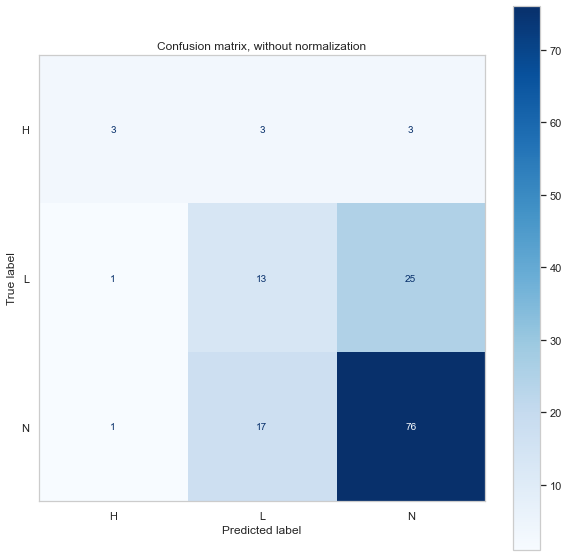

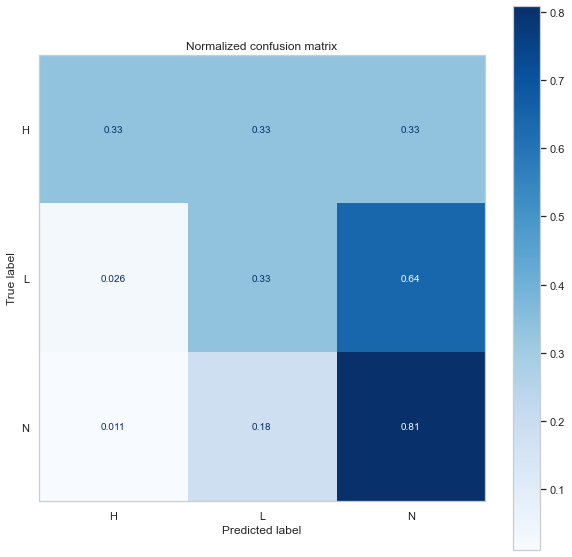

In [84]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_eval,
        y_eval,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

As you can see from the shade of the plot, our model is predicting the label N much more than others.

## Check for overfitting

In [85]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_eval, y_eval)))

Training set score: 1.0000
Test set score: 0.6479


## Feature importance

Let’s also plot the feature importance to see which features matter more.



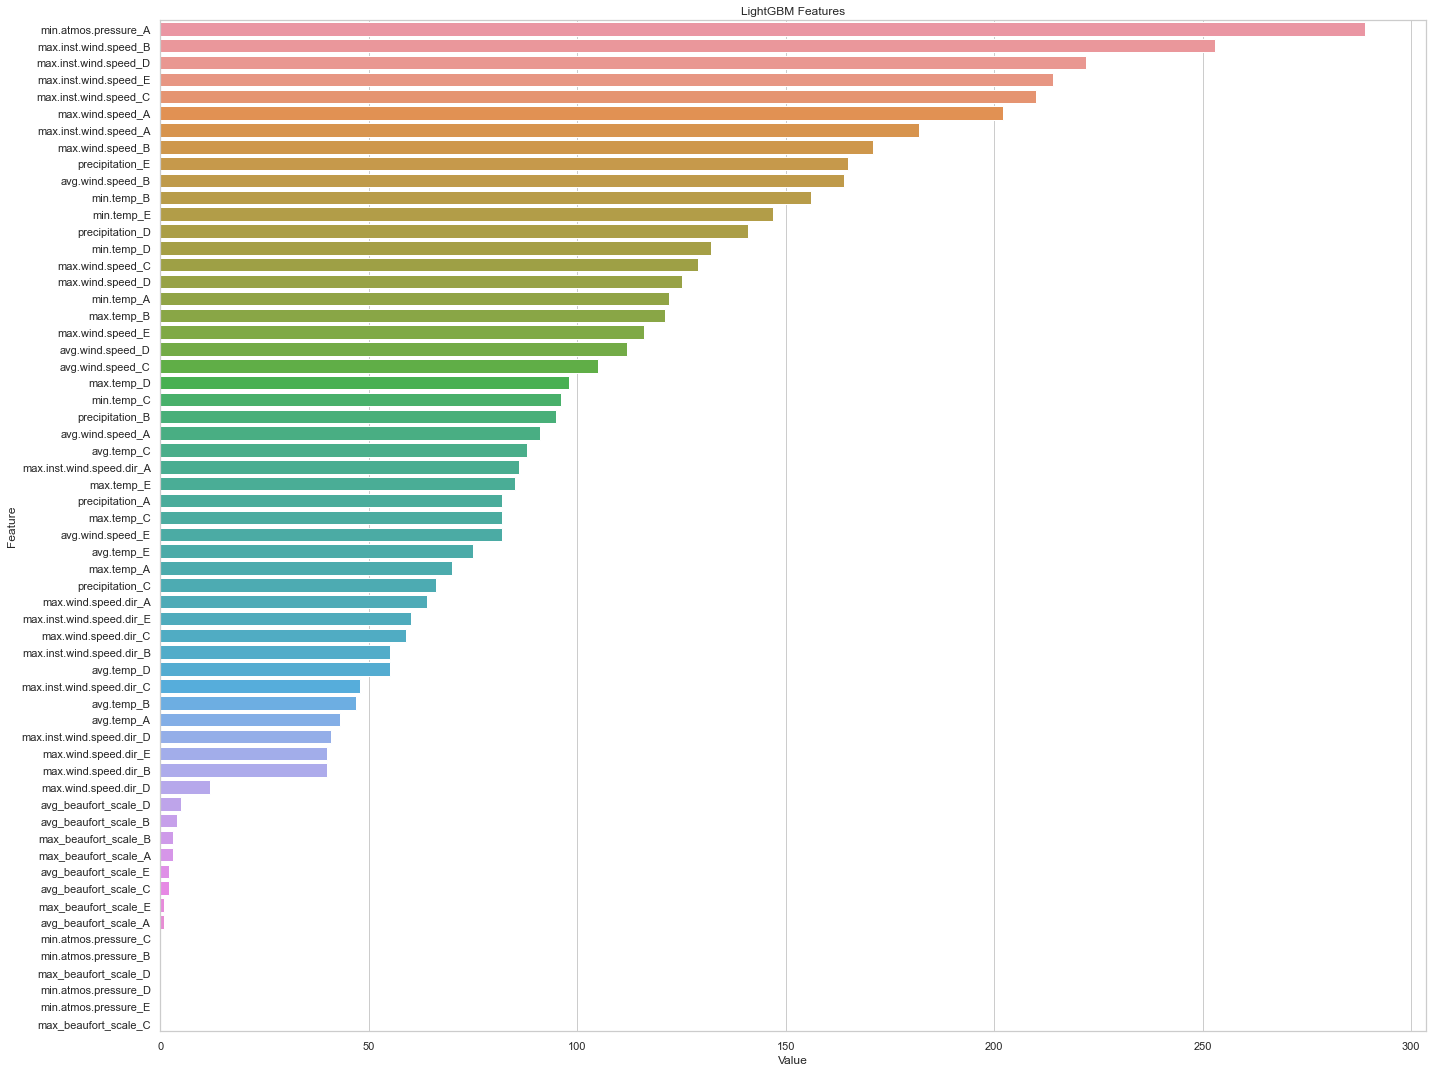

In [86]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
# plt.savefig('lightgbm_fimp.png')

## Save the model

In [87]:
# joblib.dump(clf, 'lgb1.pkl')

We have a simple model built. It’s time to predict it on the test data.


## Predict on test data

we apply the same transformation on the train data to the test data


In [88]:
test = pd.concat([test_a ,test_b ,test_c ,test_d ,test_e], keys=["A", "B", "C", "D", "E"])
test = test.reset_index()
test.rename(columns = {"level_0": "region"}, inplace=True)
test.drop(columns=['level_1'], inplace=True)

mean_atmos = test['min.atmos.pressure'].mean()
test["min.atmos.pressure"] = test['min.atmos.pressure'].fillna(mean_atmos)
test = test.ffill(axis = 0)

test = feature_eng(test)

test = test.pivot(index=["date"], columns="region")
test = pd.DataFrame(test.to_records())
test.columns = list(map(replace_all, test.columns))

In [89]:
X = test.drop('date', axis=1)

In [90]:
# Convert cat_features to pd.Categorical dtype
for col in categorical_cols:
    X[col] = pd.Categorical(X[col])

In [91]:
test_preds = clf.predict(X)
submission_df = pd.concat([test['date'], pd.DataFrame(test_preds, columns=['label'])], axis=1)
submission_df.head()

,date,label
0,0001f2fd,1
1,00177dc1,1
2,00b3a048,1
3,013f131b,2
4,01a1b150,2


In [92]:
le_name_map

{'H': 0, 'L': 1, 'N': 2}

The labels are still encoded as numeric values; let’s bring the actual label names back.

Since we already have the dictionary of the mapping of label names to numeric values, i.e. ‘H’ : 0, we can reverse the dictionary above to map the numbers to the names



In [93]:
inv_map = {v: k for k, v in le_name_map.items()}
inv_map

{0: 'H', 1: 'L', 2: 'N'}

In [94]:
submission_df['label'] = submission_df['label'].map(inv_map)  
submission_df.head()

,date,label
0,0001f2fd,L
1,00177dc1,L
2,00b3a048,L
3,013f131b,N
4,01a1b150,N


## Solution file

In [ ]:
submission_df.to_csv('solution.csv', index=False)